# Federated Learning: Train FL Model in Python

In "Create Plan" and "Host Plan" notebooks we've created the
model and the training plan, and hosted both in PyGrid.

Such hosted FL model can be now trained using client libraries, SwiftSyft, KotlinSyft, syft.js.

In this notebook, we'll use FL Client included in the PySyft to do the training.

In [1]:
%load_ext autoreload
%autoreload 2

import torch as th
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

import syft as sy
from syft.federated.fl_client import FLClient
from syft.federated.fl_job import FLJob
from syft.grid.grid_client import GridClient

sy.make_hook(globals())

C:\Users\vegoo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vegoo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vegoo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vegoo\AppData\Roaming\Python\Python37\site-

Setting up Sandbox...
Done!


Define `on_accepted`, `on_rejected`, `on_error` handlers.

The main training loop is located inside `on_accepted` routine.

In [2]:
cycles_log = []
status = {
    "ended": False
}

# Called when client is accepted into FL cycle
def on_accepted(job: FLJob):
    print(f"Accepted into cycle {len(cycles_log) + 1}!")

    cycle_params = job.client_config
    batch_size = cycle_params["batch_size"]
    lr = cycle_params["lr"]
    max_updates = cycle_params["max_updates"]

    mnist_dataset = th.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size,
        drop_last=True,
        shuffle=True,
    )

    training_plan = job.plans["training_plan"]
    model_params = job.model.tensors()
    losses = []
    accuracies = []

    for batch_idx, (X, y) in enumerate(mnist_dataset):
        X = X.view(batch_size, -1)
        y_oh = th.nn.functional.one_hot(y, 10)
        loss, acc, *model_params = training_plan.torchscript(
            X, y_oh, th.tensor(batch_size), th.tensor(lr), *model_params
        )
        losses.append(loss.item())
        accuracies.append(acc.item())
        if batch_idx % 50 == 0:
            print("Batch %d, loss: %f, accuracy: %f" % (batch_idx, loss, acc))
        if batch_idx >= max_updates:
            break

    job.report(model_params)
    # Save losses/accuracies from cycle
    cycles_log.append((losses, accuracies))

# Called when the client is rejected from cycle
def on_rejected(job: FLJob, timeout):
    if timeout is None:
        print(f"Rejected from cycle without timeout (this means FL training is done)")
    else:
        print(f"Rejected from cycle with timeout: {timeout}")
    status["ended"] = True

# Called when error occured
def on_error(job: FLJob, error: Exception):
    print(f"Error: {error}")
    status["ended"] = True

Here we have model gateway address, model name/version,
and define routine that creates FL client and starts the FL process.

In [3]:
# Default pygrid gateway address when running locally
gatewayWsUrl = "ws://127.0.0.1:5000"

# Hosted model
model_name = "mnist"
model_version = "1.0.0"

def create_client_and_run_cycle():
    client = FLClient(url=gatewayWsUrl, auth_token="", verbose=True)
    job = client.new_job(model_name, model_version)

    # Set event handlers
    job.add_listener(job.EVENT_ACCEPTED, on_accepted)
    job.add_listener(job.EVENT_REJECTED, on_rejected)
    job.add_listener(job.EVENT_ERROR, on_error)

    # Shoot!
    job.start()


Now we're ready to start FL training.

We're going to run multiple cycles until the FL model is fully done and see the progress.

As we create & authenticate new client each time,
this emulates multiple different workers requesting a cycle and working on it.

Total number of cycles is going to be `max_workers` times `num_cycles` as set in the server config in "Host Plan" notebook. 

In [4]:
while not status["ended"]:
    create_client_and_run_cycle()

Accepted into cycle 1!
Batch 0, loss: 0.236968, accuracy: 0.109375
Batch 50, loss: 0.231753, accuracy: 0.078125
Batch 100, loss: 0.230056, accuracy: 0.109375
Accepted into cycle 2!
Batch 0, loss: 0.236374, accuracy: 0.062500
Batch 50, loss: 0.231296, accuracy: 0.062500
Batch 100, loss: 0.228254, accuracy: 0.140625
Accepted into cycle 3!
Batch 0, loss: 0.234874, accuracy: 0.078125
Batch 50, loss: 0.233190, accuracy: 0.140625
Batch 100, loss: 0.227870, accuracy: 0.171875
Accepted into cycle 4!
Batch 0, loss: 0.229744, accuracy: 0.109375
Batch 50, loss: 0.227100, accuracy: 0.187500
Batch 100, loss: 0.221946, accuracy: 0.281250
Accepted into cycle 5!
Batch 0, loss: 0.231936, accuracy: 0.078125
Batch 50, loss: 0.227632, accuracy: 0.093750
Batch 100, loss: 0.220133, accuracy: 0.296875
Accepted into cycle 6!
Batch 0, loss: 0.227878, accuracy: 0.125000
Batch 50, loss: 0.228639, accuracy: 0.187500
Batch 100, loss: 0.225789, accuracy: 0.171875
Accepted into cycle 7!
Batch 0, loss: 0.223227, accu

Let's plot loss and accuracy statistics recorded from each client/cycle.
Each such cycle is drawn with different color.

It's visible that loss/accuracy improvement occurs after each 3 cycles,
because pygrid updates the model and creates new checkpoint after
receiving 3 updates from FL clients (this is controlled by `max_workers` parameter).

Cycle 1:	Loss: 0.2325893650845726	Acc: 0.09112004950495049
Cycle 2:	Loss: 0.232546269155965	Acc: 0.0922029702970297
Cycle 3:	Loss: 0.23262781288364145	Acc: 0.09328589108910891
Cycle 4:	Loss: 0.22549870477454498	Acc: 0.18208539603960397
Cycle 5:	Loss: 0.22577234394479506	Acc: 0.1813118811881188
Cycle 6:	Loss: 0.22611563704391519	Acc: 0.17264851485148514
Cycle 7:	Loss: 0.21966964552308074	Acc: 0.2875928217821782
Cycle 8:	Loss: 0.21950490330115402	Acc: 0.29254331683168316
Cycle 9:	Loss: 0.2194711304832213	Acc: 0.2871287128712871
Cycle 10:	Loss: 0.21389301209756645	Acc: 0.3978960396039604
Cycle 11:	Loss: 0.2136503117214335	Acc: 0.3941831683168317
Cycle 12:	Loss: 0.21344301650429717	Acc: 0.3969678217821782
Cycle 13:	Loss: 0.20770099980406243	Acc: 0.4927289603960396
Cycle 14:	Loss: 0.20738294956707717	Acc: 0.49504950495049505
Cycle 15:	Loss: 0.20799195677927224	Acc: 0.47926980198019803


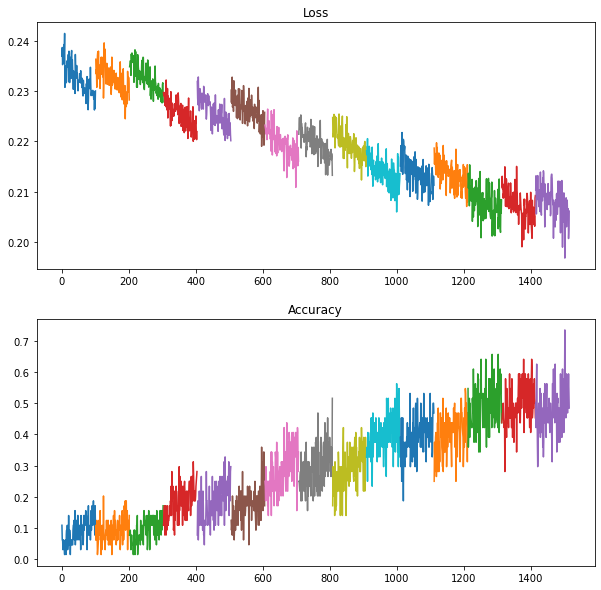

In [5]:
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")
offset = 0
for i, cycle_log in enumerate(cycles_log):
    losses, accuracies = cycle_log
    x = range(offset, offset + len(losses))
    axs[0].plot(x, losses)
    axs[1].plot(x, accuracies)
    offset += len(losses)
    print(f"Cycle {i + 1}:\tLoss: {np.mean(losses)}\tAcc: {np.mean(accuracies)}")

### TODO

Bonus track: download resulting model checkpoint and test accuracy on it.

We don't have a way to download model w/o active cycle!

In [6]:
grid = GridClient(id="", address=gatewayWsUrl, secure=False)
#grid.get_model(...)